Summary: Occurences of differences were observed for different ranges of feature LSTAT, which is one of the most important features responsible for the differences.
- For values between 1.65 and 8.3, A may predict 2 while B predicts 1,
- for values up to 14.65, A may predict 1 while B predicts 2,
- for values above 9.55, A may predict 1 while B predicts 0,
- for values above 13.95, A may predict 0 while B predicts 1.

In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules
from tasks.boston_housing import make_task4 as make_task

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Global explanations

In [6]:
mclass_diff = comparer.predict_mclass_diff(X)

In [7]:
def explain(max_depth=None, tree_fig_size=(28, 14)):
    global tree
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_explain, y_explain)
    
    feature_importances = tree.feature_importances_
    feature_order = np.flip(np.argsort(feature_importances))
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_title('Relative feature importance')
    ax.scatter(np.flip(feature_importances[feature_order]),
               np.flip(comparer.feature_names[feature_order]))
    plt.show()
    
    if tree.get_depth() <= 3:
        fig, ax = plt.subplots(figsize=(14, 14))
        plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, node_ids=True, precision=2)
        plt.show()
    
    y_test = mclass_diff == np.where(comparer.class_names == focus_class)[0][0]
    print_rules(tree, feature_names, class_names, focus_class, X_test=X, y_test=y_test, precision=2, feature_order=feature_order)
    
    print('\ngenerated data evaluation:')
    print(classification_report(y_explain, tree.predict(X_explain), target_names=class_names))

    print('\noriginal data evaluation:')
    print(classification_report(mclass_diff == np.where(comparer.class_names == focus_class)[0][0], tree.predict(X), target_names=class_names))

## $(0,1)$

In [35]:
focus_class = '(0, 1)'

In [9]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 10min 9s, sys: 7.74 s, total: 10min 17s
Wall time: 11min 6s


In [36]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [37]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

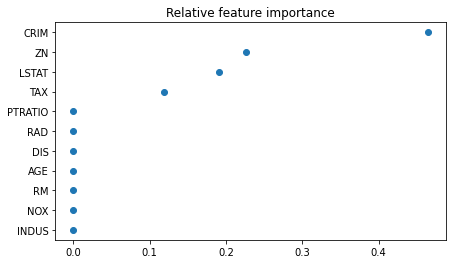

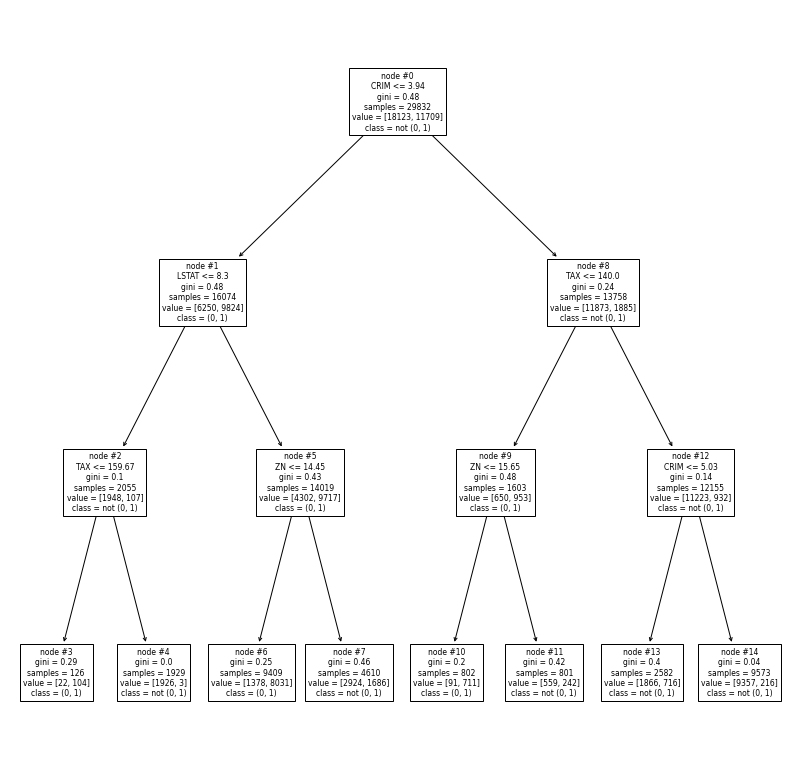

node #6: if (CRIM <= 3.94) and (ZN <= 14.45) and (LSTAT > 8.3) then class (0, 1) (covers 0.854 of 9409 instances)
node #10: if (CRIM > 3.94) and (ZN <= 15.65) and (TAX <= 140.0) then class (0, 1) (covers 0.887 of 802 instances)
node #3: if (CRIM <= 3.94) and (LSTAT <= 8.3) and (TAX <= 159.67) then class (0, 1) (covers 0.825 of 126 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       0.85      0.92      0.88     18123
      (0, 1)       0.86      0.76      0.80     11709

    accuracy                           0.85     29832
   macro avg       0.85      0.84      0.84     29832
weighted avg       0.85      0.85      0.85     29832


original data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       1.00      0.67      0.81       243
      (0, 1)       0.04      1.00      0.07         3

    accuracy                           0.68       246
   macro avg       0.52      0.84      0.44       246
we

In [12]:
explain(max_depth=3)

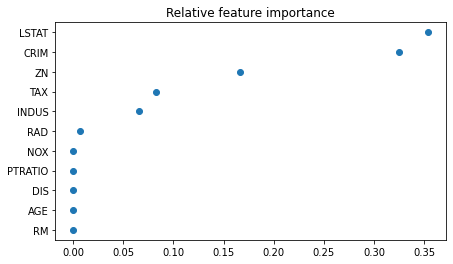

node #11: if (LSTAT > 8.3) and (LSTAT <= 24.17) and (CRIM <= 3.94) and (ZN <= 14.45) then class (0, 1) (covers 0.908 of 8814 instances)
node #15: if (LSTAT > 17.42) and (CRIM <= 3.94) and (ZN > 14.45) then class (0, 1) (covers 0.794 of 2057 instances)
node #27: if (CRIM > 3.94) and (CRIM <= 5.03) and (TAX > 140.0) and (INDUS > 15.32) then class (0, 1) (covers 0.864 of 752 instances)
node #20: if (CRIM > 3.94) and (ZN > 2.38) and (ZN <= 15.65) and (TAX <= 140.0) then class (0, 1) (covers 0.978 of 721 instances)
node #23: if (LSTAT > 25.58) and (CRIM > 3.94) and (ZN > 15.65) and (TAX <= 140.0) then class (0, 1) (covers 0.991 of 231 instances)
node #5: if (LSTAT <= 8.3) and (CRIM > 0.92) and (CRIM <= 3.94) and (TAX <= 159.67) then class (0, 1) (covers 1.0 of 104 instances)
node #30: if (CRIM > 5.03) and (TAX > 140.0) and (RAD > 21.75) then class (0, 1) (covers 0.709 of 79 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       0.98 

In [38]:
explain(max_depth=4)

## $(1,0)$

In [39]:
focus_class = '(1, 0)'

In [14]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 9min 57s, sys: 6.88 s, total: 10min 4s
Wall time: 10min 36s


In [40]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [41]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

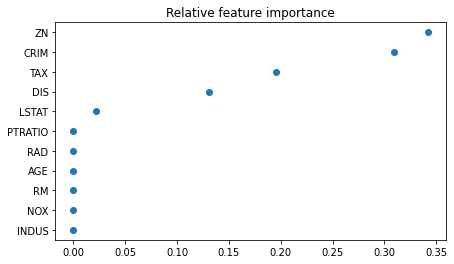

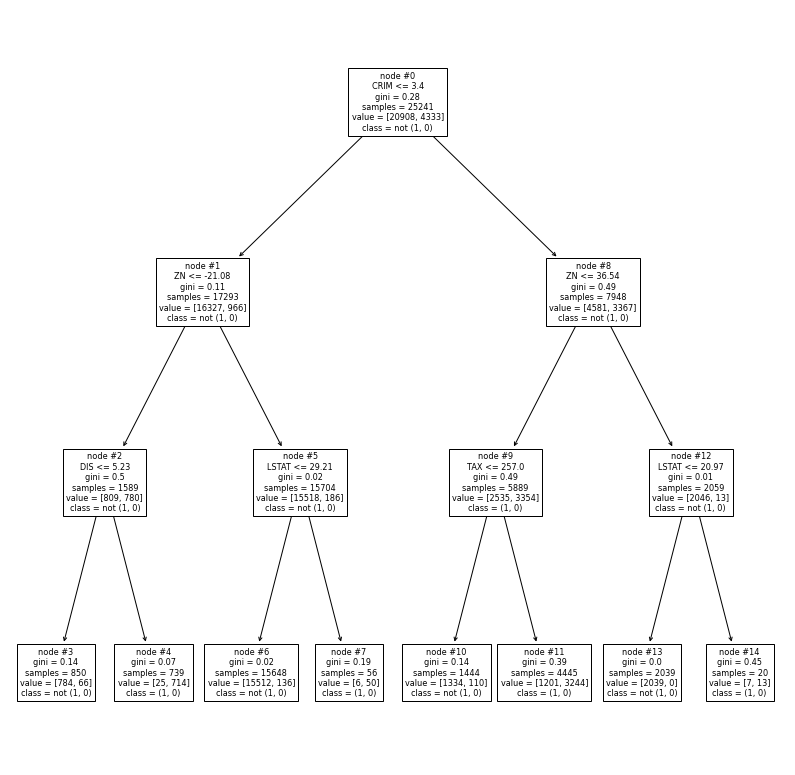

node #11: if (ZN <= 36.54) and (CRIM > 3.4) and (TAX > 257.0) then class (1, 0) (covers 0.73 of 4445 instances)
node #4: if (ZN <= -21.08) and (CRIM <= 3.4) and (DIS > 5.23) then class (1, 0) (covers 0.966 of 739 instances)
node #7: if (ZN > -21.08) and (CRIM <= 3.4) and (LSTAT > 29.21) then class (1, 0) (covers 0.893 of 56 instances)
node #14: if (ZN > 36.54) and (CRIM > 3.4) and (LSTAT > 20.97) then class (1, 0) (covers 0.65 of 20 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       0.98      0.94      0.96     20908
      (1, 0)       0.76      0.93      0.84      4333

    accuracy                           0.94     25241
   macro avg       0.87      0.93      0.90     25241
weighted avg       0.95      0.94      0.94     25241


original data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       0.99      0.74      0.85       244
      (1, 0)       0.00      0.00      0.00         2

    ac

In [42]:
explain(max_depth=3)

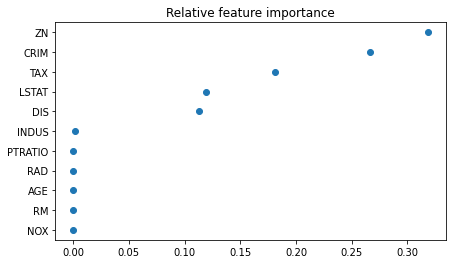

node #23: if (ZN <= 36.54) and (CRIM > 3.4) and (TAX > 257.0) and (LSTAT > 8.98) then class (1, 0) (covers 0.885 of 3173 instances)
node #7: if (ZN <= -21.08) and (CRIM <= 3.4) and (LSTAT <= 9.02) and (DIS > 5.23) then class (1, 0) (covers 0.982 of 727 instances)
node #20: if (ZN > 36.49) and (ZN <= 36.54) and (CRIM > 3.4) and (TAX <= 257.0) then class (1, 0) (covers 0.82 of 111 instances)
node #15: if (ZN > -21.08) and (CRIM <= 3.4) and (TAX > 386.36) and (LSTAT > 29.21) then class (1, 0) (covers 1.0 of 50 instances)
node #12: if (ZN > -21.08) and (CRIM <= 3.4) and (TAX > 707.24) and (LSTAT <= 29.21) then class (1, 0) (covers 0.688 of 32 instances)
node #28: if (ZN > 36.54) and (CRIM > 3.4) and (LSTAT > 20.97) and (INDUS > 18.57) then class (1, 0) (covers 1.0 of 12 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       0.97      0.98      0.98     20908
      (1, 0)       0.90      0.85      0.88      4333

    accuracy        

In [43]:
explain(max_depth=4)

## $(1,2)$

In [44]:
focus_class = '(1, 2)'

In [19]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 10min 8s, sys: 7.68 s, total: 10min 16s
Wall time: 11min 1s


In [45]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [46]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

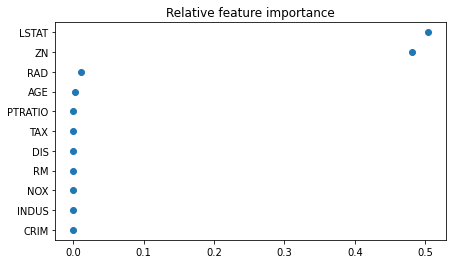

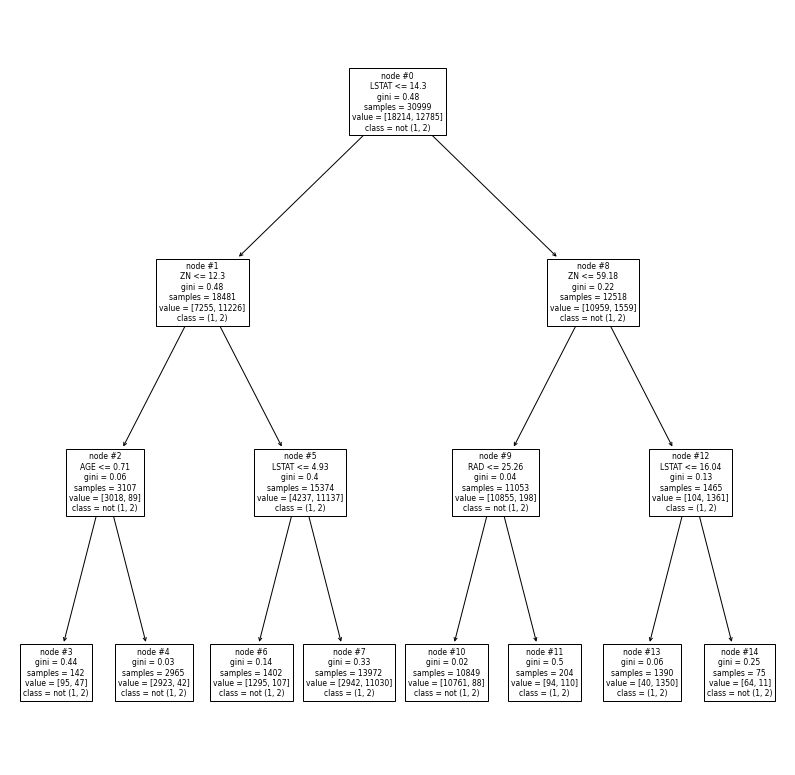

node #7: if (LSTAT > 4.93) and (LSTAT <= 14.3) and (ZN > 12.3) then class (1, 2) (covers 0.789 of 13972 instances)
node #13: if (LSTAT > 14.3) and (LSTAT <= 16.04) and (ZN > 59.18) then class (1, 2) (covers 0.971 of 1390 instances)
node #11: if (LSTAT > 14.3) and (ZN <= 59.18) and (RAD > 25.26) then class (1, 2) (covers 0.539 of 204 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 2)       0.98      0.83      0.90     18214
      (1, 2)       0.80      0.98      0.88     12785

    accuracy                           0.89     30999
   macro avg       0.89      0.90      0.89     30999
weighted avg       0.91      0.89      0.89     30999


original data evaluation:
              precision    recall  f1-score   support

  not (1, 2)       1.00      0.87      0.93       241
      (1, 2)       0.14      1.00      0.24         5

    accuracy                           0.87       246
   macro avg       0.57      0.94      0.59       246


In [47]:
explain(max_depth=3)

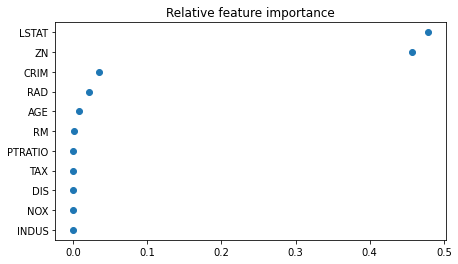

node #15: if (LSTAT > 4.93) and (LSTAT <= 14.3) and (ZN > 12.3) and (CRIM > 0.35) then class (1, 2) (covers 0.829 of 12384 instances)
node #27: if (LSTAT > 14.3) and (LSTAT <= 16.04) and (ZN > 59.18) and (RM > 5.93) then class (1, 2) (covers 0.982 of 1360 instances)
node #22: if (LSTAT > 14.3) and (LSTAT <= 15.39) and (ZN <= 59.18) and (RAD > 25.26) then class (1, 2) (covers 0.735 of 147 instances)
node #11: if (LSTAT <= 4.93) and (ZN > 12.3) and (RAD <= -8.52) then class (1, 2) (covers 0.969 of 64 instances)
node #5: if (LSTAT <= 14.3) and (ZN <= 12.3) and (AGE > 0.71) and (AGE <= 0.71) then class (1, 2) (covers 1.0 of 39 instances)
node #30: if (LSTAT > 16.04) and (ZN > 79.88) then class (1, 2) (covers 0.727 of 11 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 2)       0.94      0.88      0.91     18214
      (1, 2)       0.84      0.92      0.88     12785

    accuracy                           0.90     30999
   macro avg     

In [48]:
explain(max_depth=4)

## $(2,1)$

In [49]:
focus_class = '(2, 1)'

In [24]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 9min 52s, sys: 6.77 s, total: 9min 59s
Wall time: 10min 27s


In [50]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [51]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

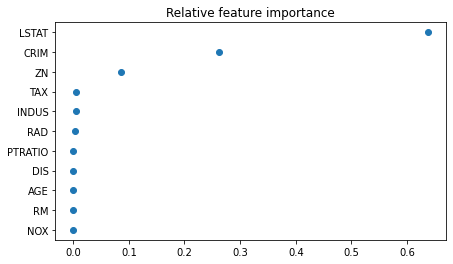

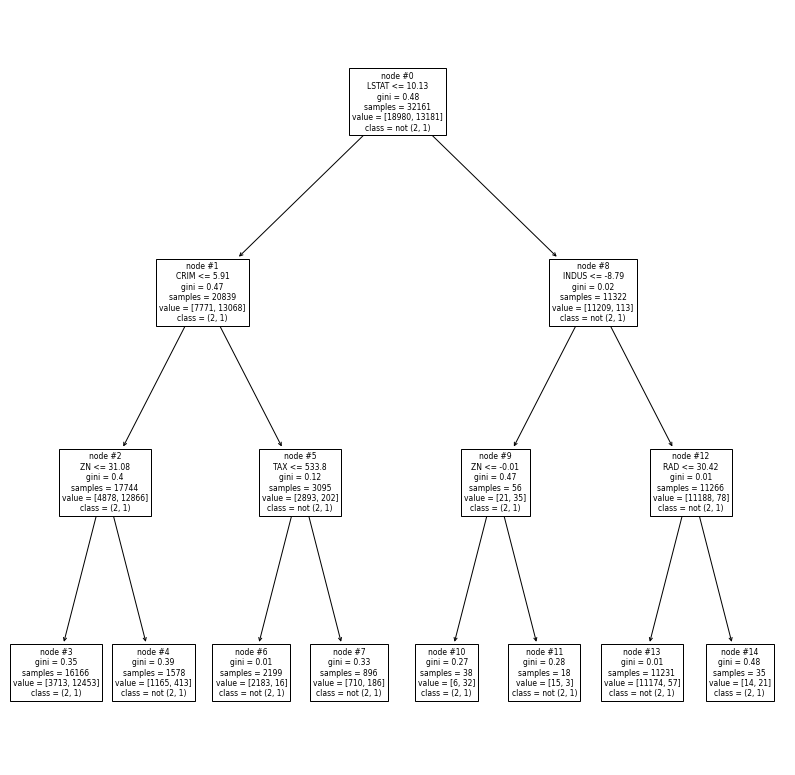

node #3: if (LSTAT <= 10.13) and (CRIM <= 5.91) and (ZN <= 31.08) then class (2, 1) (covers 0.77 of 16166 instances)
node #10: if (LSTAT > 10.13) and (ZN <= -0.01) and (INDUS <= -8.79) then class (2, 1) (covers 0.842 of 38 instances)
node #14: if (LSTAT > 10.13) and (INDUS > -8.79) and (RAD > 30.42) then class (2, 1) (covers 0.6 of 35 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (2, 1)       0.96      0.80      0.87     18980
      (2, 1)       0.77      0.95      0.85     13181

    accuracy                           0.86     32161
   macro avg       0.86      0.88      0.86     32161
weighted avg       0.88      0.86      0.86     32161


original data evaluation:
              precision    recall  f1-score   support

  not (2, 1)       1.00      0.68      0.81       244
      (2, 1)       0.03      1.00      0.05         2

    accuracy                           0.68       246
   macro avg       0.51      0.84      0.43       24

In [52]:
explain(max_depth=3)

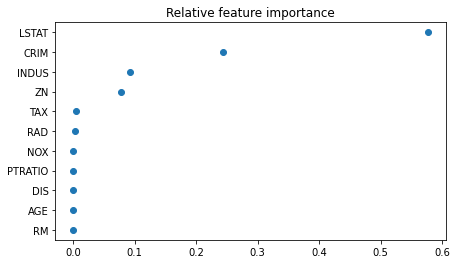

node #4: if (LSTAT <= 10.13) and (CRIM <= 5.91) and (INDUS <= 24.95) and (ZN <= 31.08) then class (2, 1) (covers 0.801 of 15513 instances)
node #7: if (LSTAT <= 10.13) and (CRIM <= -4.05) and (ZN > 31.08) then class (2, 1) (covers 0.557 of 291 instances)
node #14: if (LSTAT <= 10.13) and (CRIM > 5.91) and (INDUS <= 15.19) and (TAX > 533.8) then class (2, 1) (covers 0.596 of 280 instances)
node #19: if (LSTAT > 10.13) and (LSTAT <= 12.87) and (INDUS <= -8.79) and (ZN <= -0.01) then class (2, 1) (covers 0.939 of 33 instances)
node #30: if (LSTAT > 10.13) and (INDUS > 23.05) and (RAD > 30.42) then class (2, 1) (covers 1.0 of 21 instances)
node #23: if (LSTAT > 10.13) and (INDUS <= -8.79) and (ZN > -0.01) and (NOX > 0.62) then class (2, 1) (covers 0.75 of 4 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (2, 1)       0.98      0.82      0.89     18980
      (2, 1)       0.79      0.97      0.87     13181

    accuracy                     

In [53]:
explain(max_depth=4)